In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import gc


# xsuite
import xtrack as xt
import xmask as xm
import xfields as xf
import xpart as xp
import xobjects as xo


# BBStudies
import sys
sys.path.append('/Users/pbelanger/ABPLocal/BBStudies')
sys.path.append('/home/phbelang/abp/BBStudies')
import BBStudies.Tracking.XsuitePlus as xPlus
import BBStudies.Tracking.InteractionPoint as inp
import BBStudies.Physics.Detuning as tune
import BBStudies.Plotting.BBPlots as bbplt
import BBStudies.Physics.Base as phys
import BBStudies.Physics.Constants as cst

# JOB imports
import importlib
sys.path.append('../../')
main_002 = importlib.import_module('Jobs.002_user_specific_tasks.main')
main = importlib.import_module('Jobs.003_particle_dist_and_track.main')





tracked   = xPlus.Tracking_Interface.from_parquet('zfruits/split_tracking_2s' ,partition_name='CHUNK',
                    start_at_turn = 1347,
                    stop_at_turn  = 1796)
tracked2   = xPlus.Tracking_Interface.from_parquet('zfruits/split_tracking_2s' ,partition_name='CHUNK',
                    start_at_turn = 6286,
                    stop_at_turn  = 6735)
tracked3   = xPlus.Tracking_Interface.from_parquet('zfruits/split_tracking_2s' ,partition_name='CHUNK',
                    start_at_turn = 20205,
                    stop_at_turn  = 20654)
processed = xPlus.Tracking_Interface.from_parquet('zfruits/processed_tracking_2s')#,partition_name='CHUNK')#,partition_ID='0001')
# sub       = processed.data[processed.data.start_at_turn==1347].copy()

# tracked   = xPlus.Tracking_Interface.from_parquet('zfruits/tracking' ,partition_name='BUNCH',partition_ID='0224')
# calculations = xPlus.Tracking_Interface.from_parquet('zfruits/calculations',partition_name='BUNCH',partition_ID='0224')






# # Adding Caclulations in sig coordinates
# _self_sig = []
# _self     = calculations
# _df       = _self.calculations
# _phase_space = ['x','px','y','py','zeta','pzeta']
# for ii in ['min','max']:
#     renaming = {f'{key}_{ii}':key for key in _phase_space}
#     _n   = xPlus.W_phys2norm(**_df.rename(columns=renaming)[_phase_space],W_matrix=_self.W_matrix,particle_on_co=_self.particle_on_co,to_pd=True)
#     _sig = xPlus.norm2sigma(**_n[['x_n','px_n','y_n','py_n','zeta_n','pzeta_n']],nemitt_x= _self.nemitt_x, nemitt_y= _self.nemitt_y, nemitt_zeta= _self.nemitt_zeta, particle_on_co=_self.particle_on_co,to_pd=True)

#     renaming = {f'{key}_sig':f'{key}_sig_{ii}' for key in _phase_space}
#     _self_sig.append(_sig.rename(columns=renaming))


# calculations.calculations_sig = None
# calculations.calculations_sig = pd.concat([_df[['start_at_turn','stop_at_turn','particle']]] + _self_sig,axis=1)




In [2]:
processed.data

,Chunk ID,particle,state,start_at_turn,stop_at_turn,x_min,x_max,y_min,y_max,zeta_min,zeta_max,px_min,px_max,py_min,py_max,pzeta_min,pzeta_max,DATA
0,0,0,1,0,449,-0.000696,0.000691,-0.000697,0.000730,-0.000032,0.000034,-0.000014,0.000015,-0.000009,0.000009,0.000001,0.000001,1
1,0,1,1,0,449,-0.000810,0.000795,-0.000778,0.000822,-0.000041,0.000043,-0.000016,0.000017,-0.000010,0.000010,0.000001,0.000001,1
2,0,2,1,0,449,-0.000472,0.000465,-0.000362,0.000375,-0.000015,0.000018,-0.000010,0.000010,-0.000005,0.000005,0.000001,0.000001,1
3,0,3,1,0,449,-0.001883,0.001728,-0.000667,0.000618,-0.000127,0.000123,-0.000035,0.000039,-0.000006,0.000009,0.000001,0.000001,1
4,0,4,1,0,449,-0.000219,0.000225,-0.000911,0.000915,-0.000019,0.000021,-0.000004,0.000005,-0.000012,0.000011,0.000001,0.000001,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019995,50,0,0,22450,22490,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,1
1019996,50,0,0,22450,22490,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,1
1019997,50,0,0,22450,22490,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,1
1019998,50,0,0,22450,22490,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,1


In [3]:
tracked.df

,CHUNK,turn,particle,x,px,y,py,zeta,pzeta,state,at_element
0,3,1348,0,0.000455,-0.000005,-0.000404,-0.000003,0.000005,0.000001,1,0
1,3,1349,0,0.000311,-0.000011,0.000496,0.000007,0.000007,0.000001,1,0
2,3,1350,0,-0.000677,0.000013,0.000047,-0.000002,-0.000013,0.000001,1,0
3,3,1351,0,0.000177,0.000002,-0.000512,-0.000005,-0.000001,0.000001,1,0
4,3,1352,0,0.000549,-0.000014,0.000385,0.000006,0.000010,0.000001,1,0
...,...,...,...,...,...,...,...,...,...,...,...
8342162,3,1769,20021,0.004421,-0.000090,-0.002327,-0.000073,0.000974,0.000001,1,0
8342163,3,1770,20021,-0.002242,0.000008,-0.004093,0.000008,0.000905,0.000001,1,0
8342164,3,1771,20021,-0.006068,0.000132,0.009873,0.000059,0.000868,0.000001,1,0
8342165,3,1772,20021,-0.002537,0.000097,-0.008019,-0.000014,0.001032,0.000002,1,0


array([    0,     1,     2, ..., 19997, 19998, 19999])

In [12]:

particle_list[:10]

array([ 2307,  3888,    51, 10145,   843,  4948,  7797, 16050,  8239,
        5460])

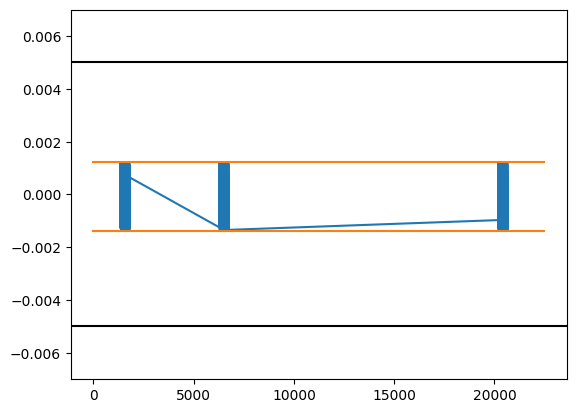

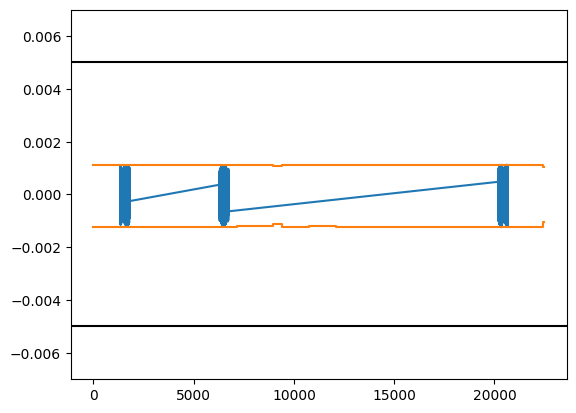

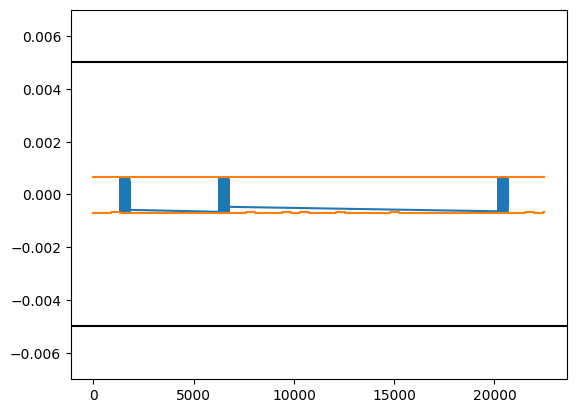

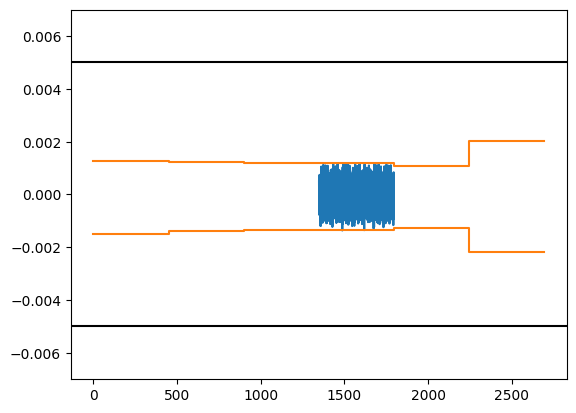

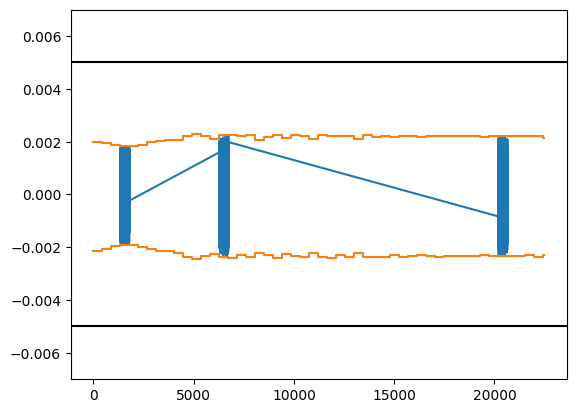

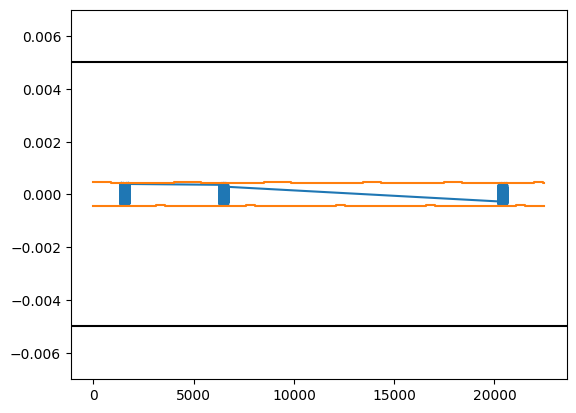

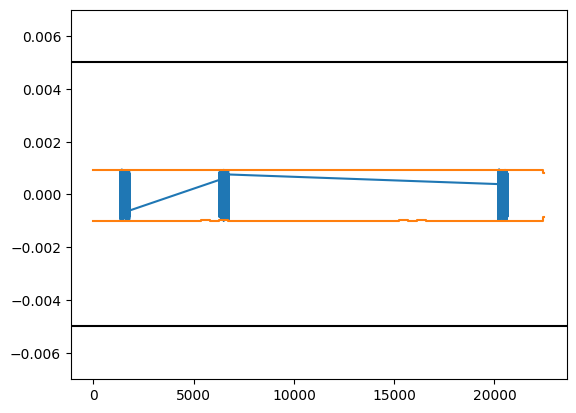

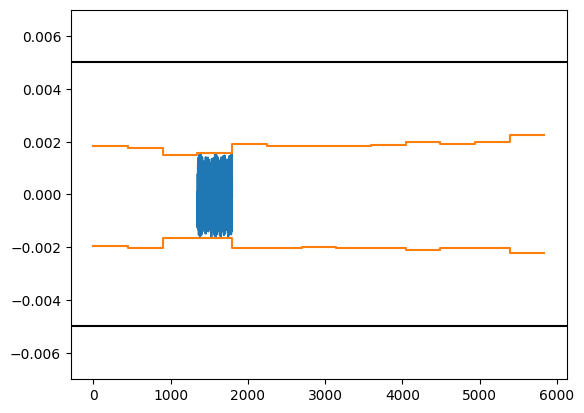

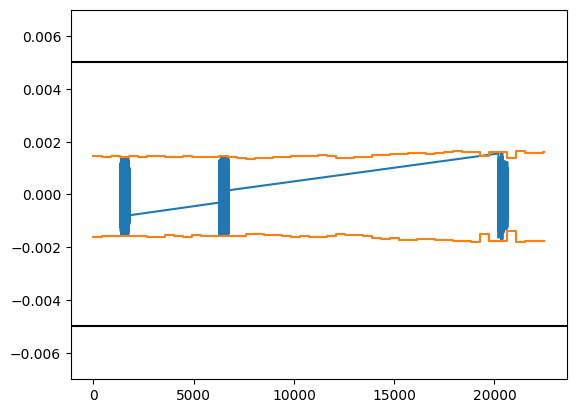

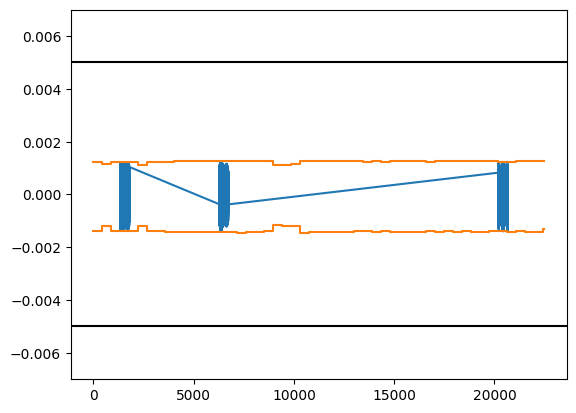

In [13]:

merged_df = pd.concat([tracked.df,tracked2.df,tracked3.df])

particle_list = processed.data.particle.unique()
np.random.seed(0)
np.random.shuffle(particle_list)

for part_ID in particle_list[:10]:

    df = merged_df.groupby('particle').get_group(part_ID)
    calc = processed.data.groupby('particle').get_group(part_ID)

    plt.figure()
    plt.plot(df.turn,df.x,'-')
    plt.step(list(calc.start_at_turn) + [list(calc.stop_at_turn)[-1]],list(calc.x_min) + [np.nan],'-',where='post')
    plt.step(list(calc.start_at_turn) + [list(calc.stop_at_turn)[-1]],list(calc.x_max) + [np.nan],'-',where='post',color='C1')
    plt.axhline(0.005,color='k')
    plt.axhline(-0.005,color='k')
    # else:
    #     continue
    plt.ylim([-0.007,0.007])

In [7]:

def split_in_chunks(turns,n_chunks = None,main_chunk = None):
    if n_chunks is not None:
        main_chunk = turns//n_chunks
        chunks     = n_chunks*[main_chunk]+ [np.mod(turns,n_chunks)]
    elif main_chunk is not None:
        n_chunks = turns//main_chunk
        chunks     = n_chunks*[main_chunk]+ [np.mod(turns,main_chunk)]
    
    if chunks[-1]==0:
        chunks = chunks[:-1]
    return chunks


True

In [4]:
chunks

[449,
 449,
 449,
 449,
 449,
 449,
 449,
 449,
 449,
 449,
 449,
 449,
 449,
 449,
 449,
 449,
 449,
 449,
 449,
 449,
 449,
 449,
 449,
 449,
 449,
 449,
 449,
 449,
 449,
 449,
 449,
 449,
 449,
 449,
 449,
 449,
 449,
 449,
 449,
 449,
 449,
 449,
 449,
 449,
 449,
 449,
 449,
 449,
 449,
 449,
 40]

In [49]:
def split_in_chunks(turns,n_chunks = None,main_chunk = None):
    if n_chunks is not None:
        main_chunk = turns//n_chunks
        chunks     = n_chunks*[main_chunk]+ [np.mod(turns,n_chunks)]
    elif main_chunk is not None:
        n_chunks = turns//main_chunk
        chunks     = n_chunks*[main_chunk]+ [np.mod(turns,main_chunk)]
    
    
    if chunks[-1]==0:
        chunks = chunks[:-1]
    return chunks


In [29]:
sum(split_in_chunks(22490,n_chunks=50))

22490

In [4]:
tracked3 = xPlus.Tracking_Interface.from_parquet('zfruits/split_tracking_2s',partition_name='CHUNK',start_at_turn=100,stop_at_turn=200)

In [5]:
tracked3.df

,CHUNK,turn,particle,x,px,y,py,zeta,pzeta,state,at_element
0,0,101,0,0.000359,-0.000002,-0.000281,-0.000001,0.000025,0.000001,1,0
1,0,102,0,0.000422,-0.000013,0.000524,0.000007,0.000031,0.000001,1,0
2,0,103,0,-0.000648,0.000011,-0.000107,-0.000004,0.000011,0.000001,1,0
3,0,104,0,0.000046,0.000005,-0.000425,-0.000003,0.000019,0.000001,1,0
4,0,105,0,0.000620,-0.000014,0.000467,0.000007,0.000033,0.000001,1,0
...,...,...,...,...,...,...,...,...,...,...,...
1973125,0,195,20021,-0.000025,-0.000004,0.001665,0.000012,0.000104,0.000001,1,0
1973126,0,196,20021,-0.000548,0.000012,-0.002201,-0.000029,0.000091,0.000001,1,0
1973127,0,197,20021,0.000421,-0.000005,0.000424,0.000016,0.000105,0.000001,1,0
1973128,0,198,20021,0.000457,-0.000012,0.002039,0.000019,0.000108,0.000001,1,0


In [6]:
tracked3

╭───────────────────────────── Tracking_Interface ──────────────────────────────╮
│ ╭───────────────────────────────────────────────────────────────────────────╮ │
│ │ <BBStudies.Tracking.XsuitePlus.RenderingTracker object at 0x7f6e34371f60> │ │
│ ╰───────────────────────────────────────────────────────────────────────────╯ │
│                                                                               │
│   context_name = 'ContextCupy'                                                │
│      exec_time = 31.501905919983983                                           │
│         method = '6d'                                                         │
│        n_parts = 20022                                                        │
│        n_turns = 449                                                          │
│       nemitt_x = 1.8e-06                                                      │
│       nemitt_y = 1.8e-06                                                      │
│    nemitt_zeta = 1                                                            │
│   parquet_data = '_df'                                                        │
│ particle_on_co = "<class 'xpart.particles.particles.Particles'>"              │
│   partition_ID = '000'                                                        │
│ partition_name = 'CHUNK'                                                      │
│  start_at_turn = 0                                                            │
│   stop_at_turn = 449                                                          │
│       W_matrix = array([[ 1.08863958e+01,  1.33319897e-15,  6.97705688e-01,   │
│                           6.00095910e-01,  1.54562553e-03, -1.91777173e-02],  │
│                         [-2.12445078e-01,  9.11656818e-02, -1.88396282e-02,   │
│                          -5.39780433e-03, -4.18823688e-05, -2.43544501e-04],  │
│                         [-1.00760338e+00,  7.89347783e-01,  1.44622766e+01,   │
│                           1.77111808e-15, -1.51968095e-03,  4.02479004e-04],  │
│                         [-1.57497085e-02,  4.85955640e-03,  1.70152481e-01,   │
│                           6.86240846e-02, -6.02321485e-06,  3.50089345e-06],  │
│                         [ 1.89073344e-01, -4.91944901e-02,  1.54425104e-02,   │
│                           7.79880301e-03,  2.81243720e+01,  3.44424221e-15],  │
│                         [-6.20239284e-06, -4.64857364e-06,  6.00971963e-06,   │
│                           3.07021757e-06, -1.53224931e-04,  3.55563916e-02]]) │
╰───────────────────────────────────────────────────────────────────────────────╯

In [3]:
tracked3.df

,CHUNK,turn,particle,x,px,y,py,zeta,pzeta,state,at_element
0,0,101,0,0.000359,-0.000002,-0.000281,-0.000001,0.000025,0.000001,1,0
1,0,102,0,0.000422,-0.000013,0.000524,0.000007,0.000031,0.000001,1,0
2,0,103,0,-0.000648,0.000011,-0.000107,-0.000004,0.000011,0.000001,1,0
3,0,104,0,0.000046,0.000005,-0.000425,-0.000003,0.000019,0.000001,1,0
4,0,105,0,0.000620,-0.000014,0.000467,0.000007,0.000033,0.000001,1,0
...,...,...,...,...,...,...,...,...,...,...,...
1973125,0,195,20021,-0.000025,-0.000004,0.001665,0.000012,0.000104,0.000001,1,0
1973126,0,196,20021,-0.000548,0.000012,-0.002201,-0.000029,0.000091,0.000001,1,0
1973127,0,197,20021,0.000421,-0.000005,0.000424,0.000016,0.000105,0.000001,1,0
1973128,0,198,20021,0.000457,-0.000012,0.002039,0.000019,0.000108,0.000001,1,0


In [22]:
tracked2.df.groupby('CHUNK').count()

/tmp/ipykernel_3861130/64955887.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tracked2.df.groupby('CHUNK').count()


,turn,particle,x,px,y,py,zeta,pzeta,state,at_element
CHUNK,,,,,,,,,,
0,3994996,3994996,3994996,3994996,3994996,3994996,3994996,3994996,3994996,3994996
1,3940490,3940490,3940490,3940490,3940490,3940490,3940490,3940490,3940490,3940490
2,3892017,3892017,3892017,3892017,3892017,3892017,3892017,3892017,3892017,3892017
3,3851221,3851221,3851221,3851221,3851221,3851221,3851221,3851221,3851221,3851221
4,3816801,3816801,3816801,3816801,3816801,3816801,3816801,3816801,3816801,3816801
5,3784392,3784392,3784392,3784392,3784392,3784392,3784392,3784392,3784392,3784392
6,3757478,3757478,3757478,3757478,3757478,3757478,3757478,3757478,3757478,3757478
7,3733071,3733071,3733071,3733071,3733071,3733071,3733071,3733071,3733071,3733071
8,3708538,3708538,3708538,3708538,3708538,3708538,3708538,3708538,3708538,3708538


In [19]:
for (name,group),(name2,group2) in zip(tracked.df.groupby('particle'),tracked2.df.groupby('particle')):
    test = group.set_index('turn').x
    test2 = group2.set_index('turn').x

    if np.all(test==test2):
        print(name,name2)


0 0
1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9
10 10
11 11
12 12
13 13
14 14
15 15
16 16
17 17
18 18
19 19
20 20
21 21
22 22
23 23
24 24
25 25
26 26
27 27
28 28
29 29
30 30
31 31
32 32
33 33
34 34
35 35
36 36
37 37
38 38
39 39
40 40
41 41
42 42
43 43
44 44
45 45
46 46
47 47
48 48
49 49
50 50
51 51
52 52
53 53
54 54
55 55
56 56
57 57
58 58
59 59
60 60
61 61
62 62
63 63
64 64
65 65
66 66
67 67
68 68
69 69
70 70
71 71
72 72
73 73
74 74
75 75
76 76
77 77
78 78
79 79
80 80
81 81
82 82
83 83
84 84
85 85
86 86
87 87
88 88
89 89
90 90
91 91
92 92
93 93
94 94
95 95
96 96
97 97
98 98
99 99
100 100
101 101
102 102
103 103
104 104
105 105
106 106
107 107
108 108
109 109
110 110
111 111
112 112
113 113
114 114
115 115
116 116
117 117
118 118
119 119
120 120
121 121
122 122
123 123
124 124
125 125
126 126
127 127
128 128
129 129
130 130
131 131
132 132
133 133
134 134
135 135
136 136
137 137
138 138
139 139
140 140
141 141
142 142
143 143
144 144
145 145
146 146
147 147
148 148
149 149
150 150
151 151
152 

In [14]:
tracked.df.groupby('particle').get_group(100)

,BUNCH,turn,particle,x,px,y,py,zeta,pzeta,state,at_element
199698,224,0,100,0.001246,-0.000018,-0.000065,9.101550e-07,0.000020,0.000001,1,0
199699,224,1,100,0.000116,-0.000014,0.000369,4.076205e-06,0.000011,0.000001,1,0
199700,224,2,100,-0.001378,0.000031,0.000105,-2.558485e-07,-0.000024,0.000001,1,0
199701,224,3,100,0.001053,-0.000012,-0.000334,-3.734324e-06,0.000018,0.000001,1,0
199702,224,4,100,0.000489,-0.000021,0.000178,3.644338e-06,0.000019,0.000001,1,0
...,...,...,...,...,...,...,...,...,...,...,...
201693,224,1995,100,-0.000681,0.000008,0.000634,1.244456e-05,-0.000071,0.000001,1,0
201694,224,1996,100,-0.000434,0.000015,0.000801,5.015819e-06,-0.000074,0.000001,1,0
201695,224,1997,100,0.000922,-0.000017,-0.001184,-1.540489e-05,-0.000047,0.000001,1,0
201696,224,1998,100,-0.000251,-0.000003,0.000198,8.097999e-06,-0.000063,0.000001,1,0


In [17]:
np.all(tracked2.df.groupby('particle').get_group(100).set_index('turn').x == tracked.df.groupby('particle').get_group(100).set_index('turn').x)

True

---
# Computing particles lost on collimator
---

In [16]:
xt.ParticlesMonitor( _context         = self.context,
                                                        start_at_turn    = last_turn, 
                                                        stop_at_turn     = last_turn + chunk,
                                                        n_repetitions    = 1,
                                                        repetition_period= 1,
                                                    num_particles    = self.n_parts)

NameError: name 'self' is not defined

In [ ]:

col_setting = 4 #sigma

real_x = tracked.coord[tracked.coord_sig.x_sig<col_setting].x.max()
real_y = tracked.coord[tracked.coord_sig.y_sig<col_setting].y.max()


# For regular tracking
#----------------------------------
df = tracked.df.copy()

collimator_lost     = df.groupby('particle').apply(lambda part: (np.cumsum(
                                                    # Condition: exceed col either in x or y
                                                    (part.x.abs()>real_x)|(part.y.abs()>real_y)
                                                    ).astype(bool)))
idx_collimator_lost = collimator_lost.index.get_level_values(1)

df.insert(0,'collimator_lost',False)
df.loc[idx_collimator_lost,'collimator_lost'] = collimator_lost.values
tracked.df_collimator = None
tracked.df_collimator = df
#----------------------------------


# For calculations
#----------------------------------
df = calculations.calculations.copy()

collimator_lost     = df.groupby('particle').apply(lambda part: (np.cumsum(
                                                    # Condition: exceed col either in x or y
                                                    (part.x_min.abs()>real_x)|(part.x_max.abs()>real_x)|(part.y_min.abs()>real_y)|(part.y_max.abs()>real_y)
                                                    ).astype(bool)))
idx_collimator_lost = collimator_lost.index.get_level_values(1)

df.insert(0,'collimator_lost',False)
df.loc[idx_collimator_lost,'collimator_lost'] = collimator_lost.values
calculations.calculations_collimator = None
calculations.calculations_collimator = df
#----------------------------------

In [ ]:
%matplotlib widget

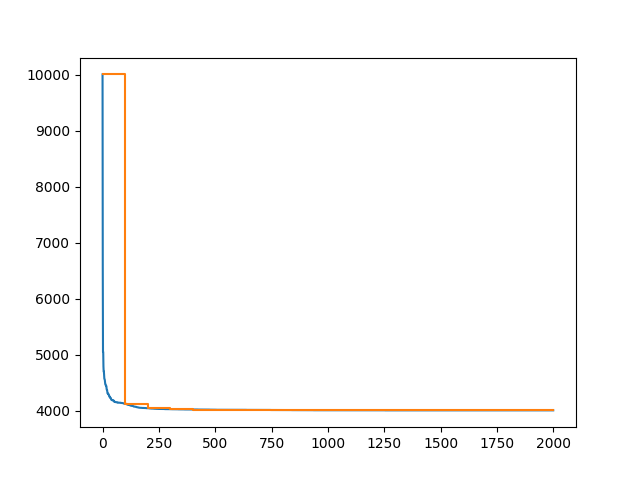

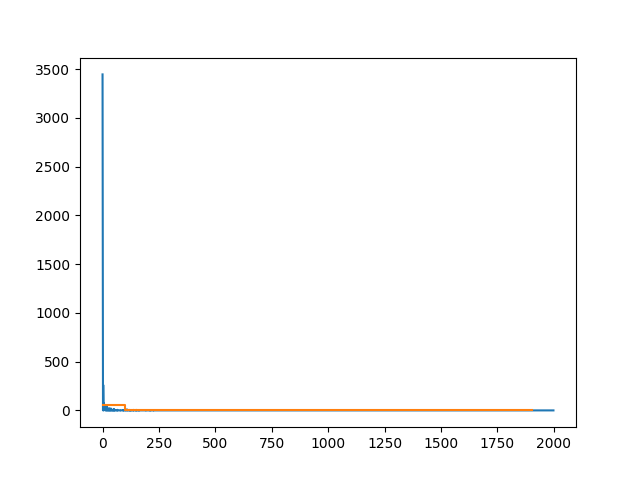

In [ ]:
Intensity_trk = tracked.df_collimator[~tracked.df_collimator.collimator_lost].groupby('turn').count().particle
Intensity_clc = calculations.calculations_collimator[~calculations.calculations_collimator.collimator_lost].groupby('stop_at_turn').count().particle


plt.figure()
plt.plot(Intensity_trk.index,Intensity_trk.values)
# plt.plot(Intensity_clc.index,Intensity_clc.values)
plt.step(Intensity_clc.index,Intensity_clc.values,'-',where='post')
# plt.ylim([7e3,9e3])



plt.figure()
plt.plot(Intensity_trk.index[:-1],-np.diff(Intensity_trk.values))
# plt.plot(Intensity_clc.index[:-1],-np.diff(Intensity_clc.values))
plt.step(Intensity_clc.index[:-1],-np.diff(Intensity_clc.values)/np.diff(Intensity_clc.index),'-',where='post')
# plt.ylim([-5,10])


In [ ]:
Intensity = df[~df.collimator_lost].groupby('turn').count().particle

plt.figure()
plt.plot(Intensity.index,Intensity.values)
plt.ylim([7e3,9e3])



plt.figure()
plt.plot(Intensity.index[:-1],-np.diff(Intensity.values))
plt.ylim([-10,25])


In [ ]:
Intensity.values[-20:]

In [ ]:
np.argmin(traj.x_sig>col_setting)

In [ ]:
collimator_lost = np.zeros()

In [ ]:
_calc_n = []
for ii in ['min','max']:
 dummy = 
 _calc_n.append(xPlus.W_phys2norm(**calculations.calculations[[f'x_{key}',f'px_{key}',f'y_{key}',f'py_{key}',f'zeta_{key}',f'pzeta_{key}']],W_matrix=calculations.W_matrix,particle_on_co=calculations.particle_on_co,to_pd=True))

In [ ]:
calculations.calculations_sig

In [ ]:
calculations.calculations

In [ ]:
_sig.rename(columns=renaming)

In [ ]:
_n

In [ ]:
calculations.calculations

In [ ]:
calculations.calculations.rename(columns={'x_min':'x'})

In [ ]:
calculations.calculations

In [ ]:
~df.collimator_lost

In [ ]:
traj = df.groupby('particle').get_group(139)

# condition = np.invert(np.cumsum(traj.x_sig>col_setting).astype(bool))

plt.figure()
plt.plot(traj.turn,traj.x_sig)
plt.plot(traj[~traj.collimator_lost].turn,traj[~traj.collimator_lost].x_sig)

plt.ylim([-20,20])

In [ ]:
collimator_lost.index.get_level_values(1)

In [ ]:
col_setting = 15
traj = df.groupby('particle').get_group(139)

condition = np.invert(np.cumsum(traj.x_sig>col_setting).astype(bool))

plt.figure()
plt.plot(traj.turn,traj.x_sig)
plt.plot(traj[condition].turn,traj[condition].x_sig)

plt.ylim([-20,20])

In [ ]:
df.groupby('particle').apply(lambda part:) 

In [ ]:
df[df.state].groupby('turn').count()

In [ ]:
calculations.calculations
coord_n = W_phys2norm(**self.df[['x','px','y','py','zeta','pzeta']],W_matrix=self.W_matrix,particle_on_co=self.particle_on_co,to_pd=True)

In [ ]:
worst_particles[1:20]

In [ ]:

# for (name,df),(name2,calc) in zip(tracked.df.groupby('particle'),calculations.calculations.groupby('particle')):
    # assert name==name2, "Problem with the particle ID"
    # if name in [10,20,30]:

worst_particles = calculations.data.groupby('particle').apply(lambda part: np.max(part.x_max)-np.min(part.x_max)).sort_values(ascending=False).index
# for part_ID in worst_particles[1:20]:#np.arange(10,20):
for part_ID in np.arange(10,20):
    df = tracked.df_sig.groupby('particle').get_group(part_ID)
    calc = calculations.calculations_sig.groupby('particle').get_group(part_ID)

    plt.figure()
    plt.plot(df.turn,df.x_sig,'-')
    plt.step(list(calc.start_at_turn) + [list(calc.stop_at_turn)[-1]],list(calc.x_sig_min) + [np.nan],'-',where='post')
    plt.step(list(calc.start_at_turn) + [list(calc.stop_at_turn)[-1]],list(calc.x_sig_max) + [np.nan],'-',where='post',color='C1')
    # plt.axhline(0.005,color='k')
    # plt.axhline(-0.005,color='k')
    # else:
    #     continue
    # plt.ylim([-0.007,0.007])

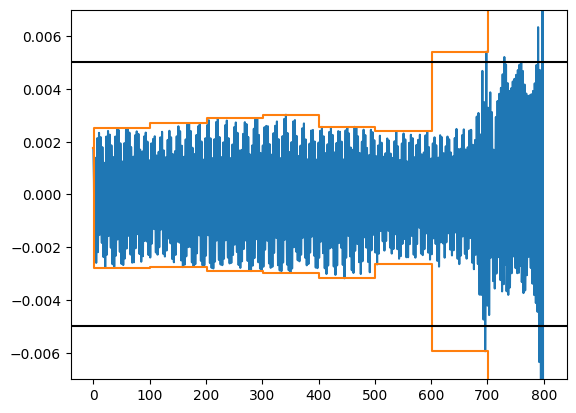

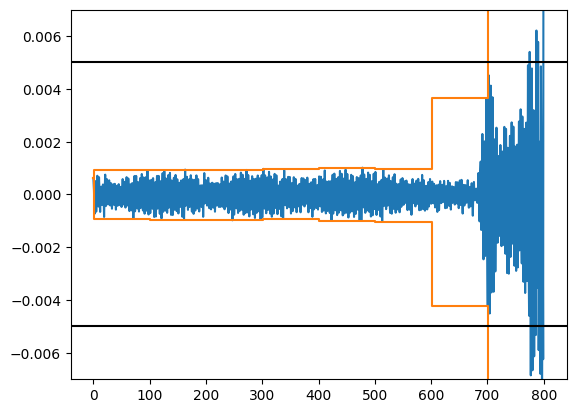

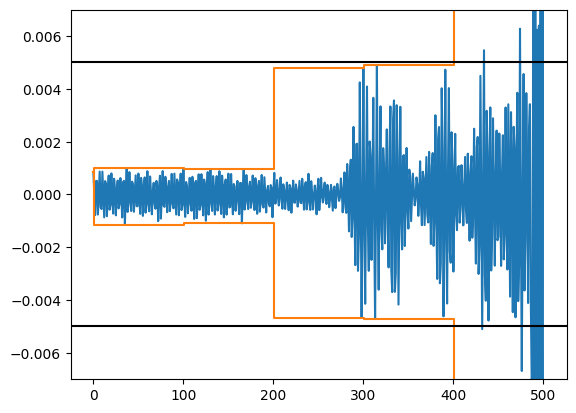

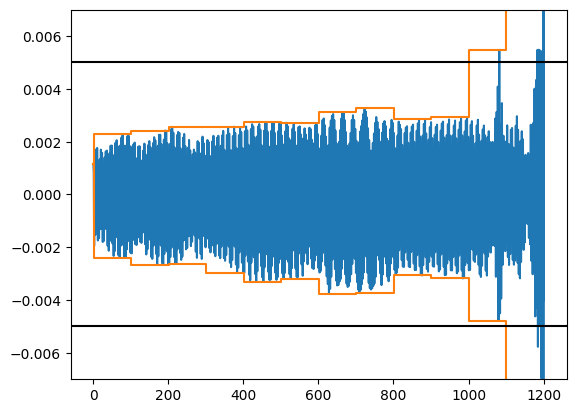

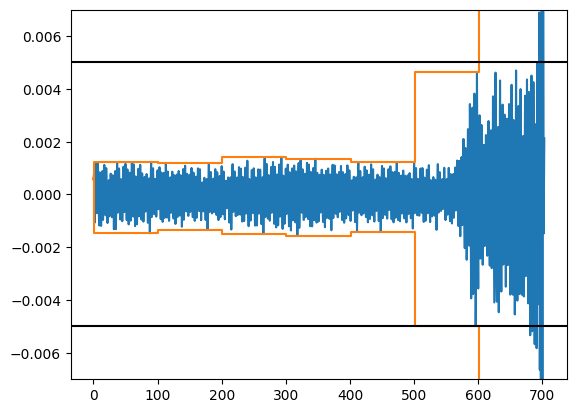

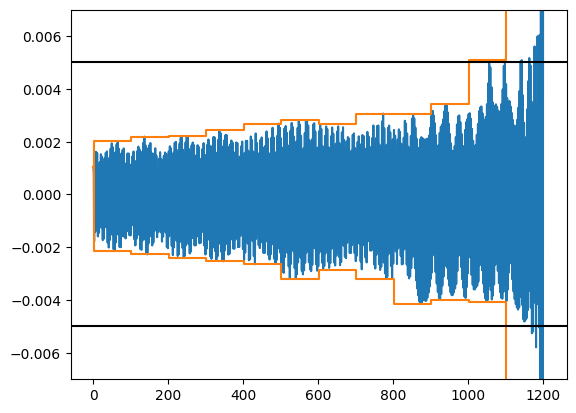

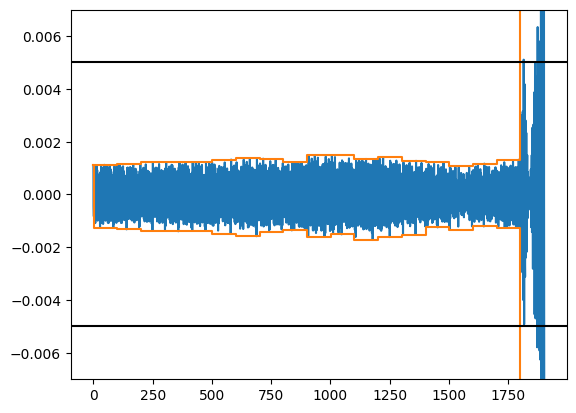

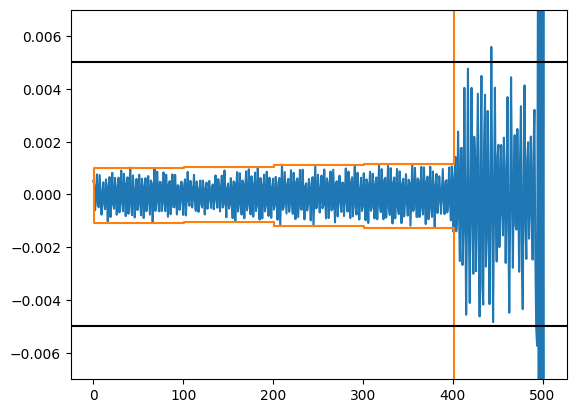

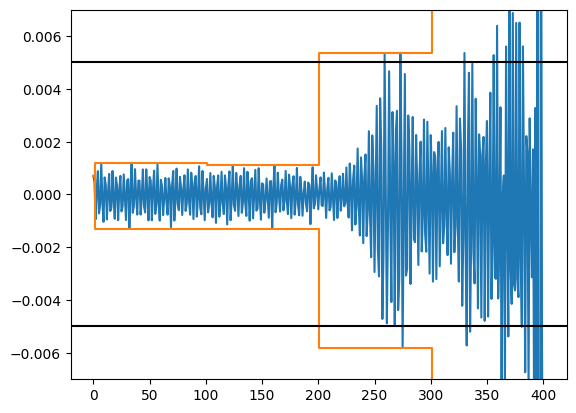

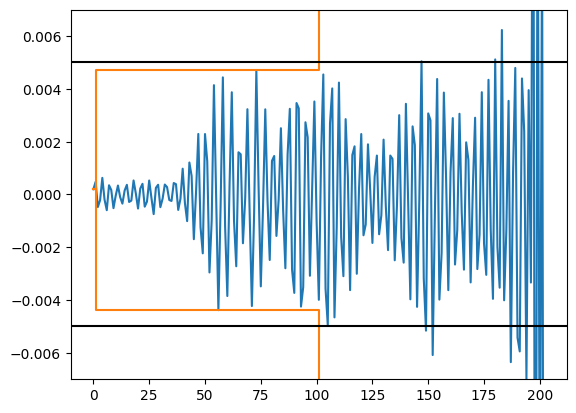

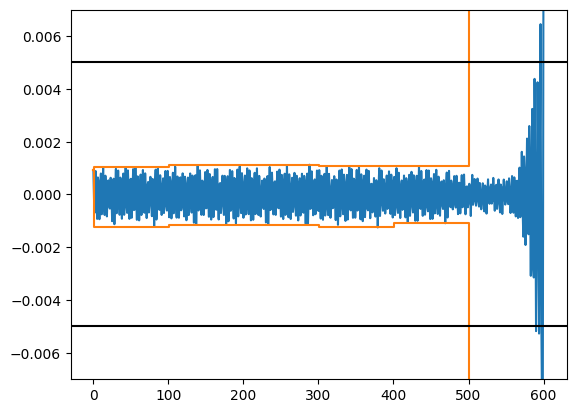

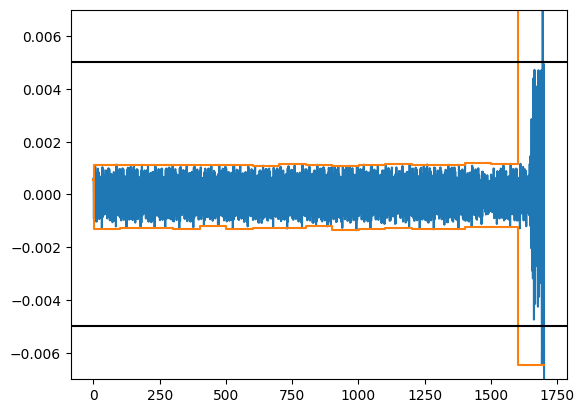

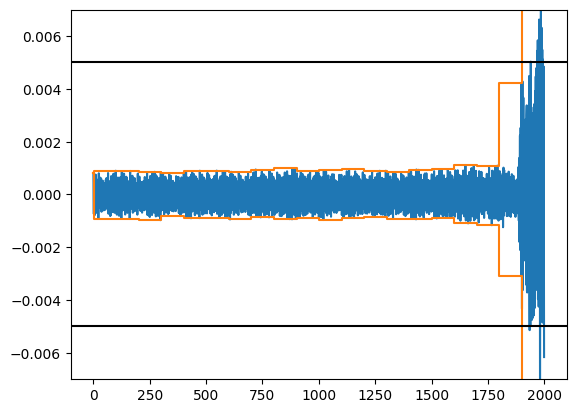

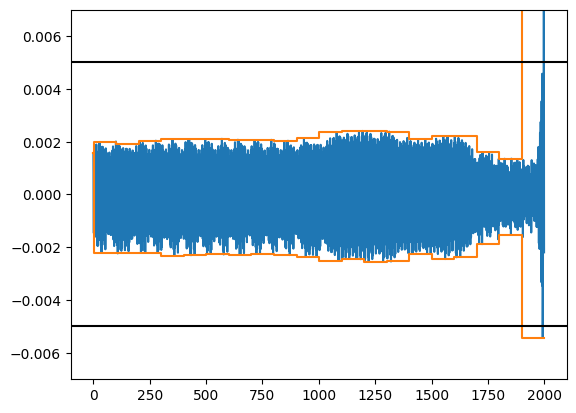

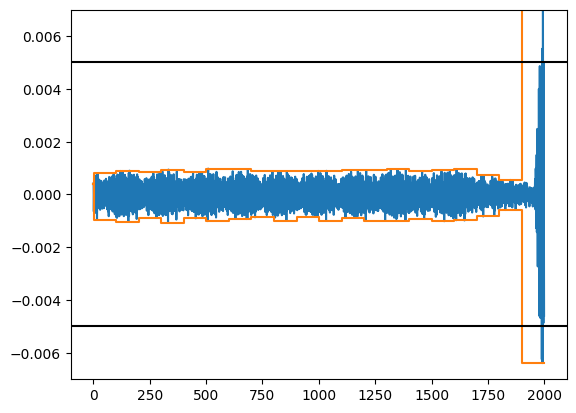

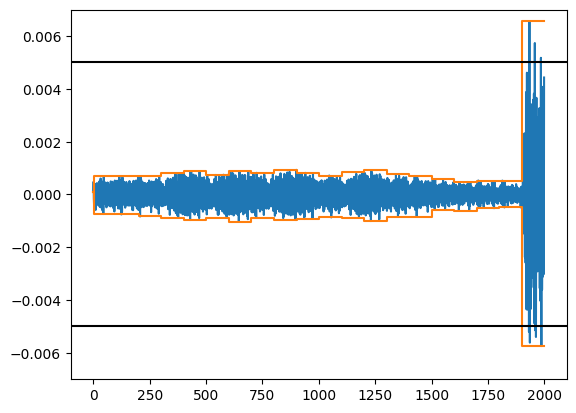

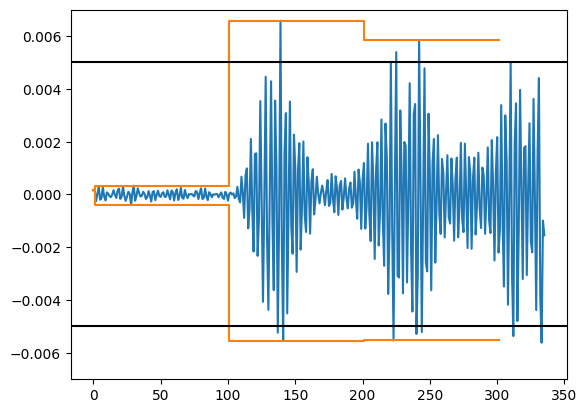

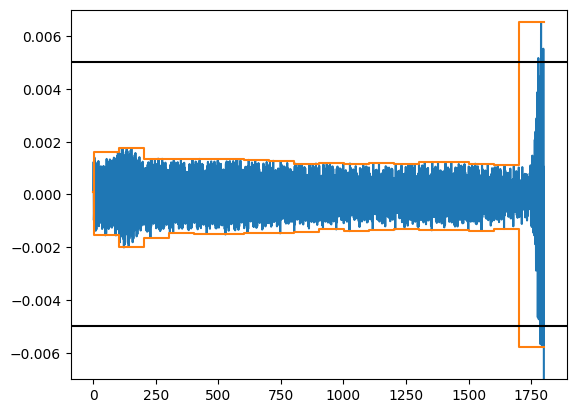

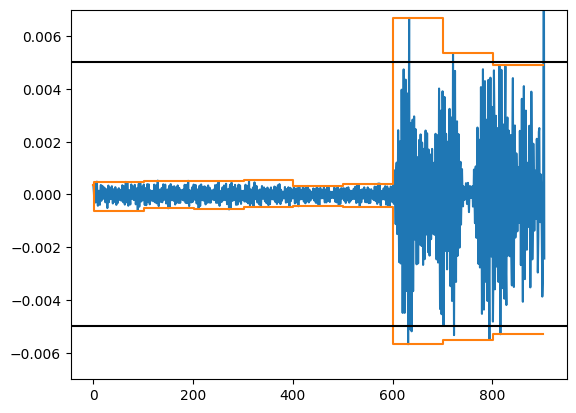

In [5]:

# for (name,df),(name2,calc) in zip(tracked.df.groupby('particle'),calculations.calculations.groupby('particle')):
    # assert name==name2, "Problem with the particle ID"
    # if name in [10,20,30]:

worst_particles = calculations.data.groupby('particle').apply(lambda part: np.max(part.x_max)-np.min(part.x_max)).sort_values(ascending=False).index
for part_ID in worst_particles[1:20]:#np.arange(10,20):
    df = tracked.df.groupby('particle').get_group(part_ID)
    calc = calculations.data.groupby('particle').get_group(part_ID)

    plt.figure()
    plt.plot(df.turn,df.x,'-')
    plt.step(list(calc.start_at_turn) + [list(calc.stop_at_turn)[-1]],list(calc.x_min) + [np.nan],'-',where='post')
    plt.step(list(calc.start_at_turn) + [list(calc.stop_at_turn)[-1]],list(calc.x_max) + [np.nan],'-',where='post',color='C1')
    plt.axhline(0.005,color='k')
    plt.axhline(-0.005,color='k')
    # else:
    #     continue
    plt.ylim([-0.007,0.007])

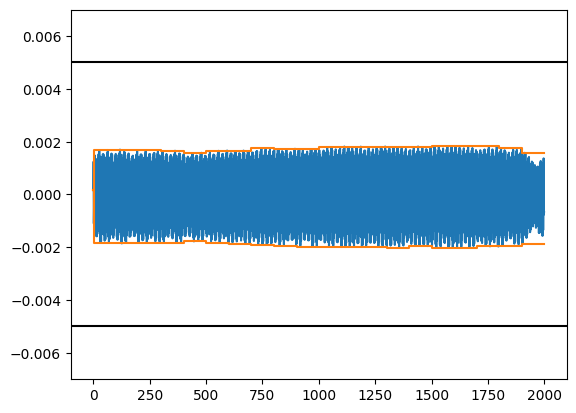

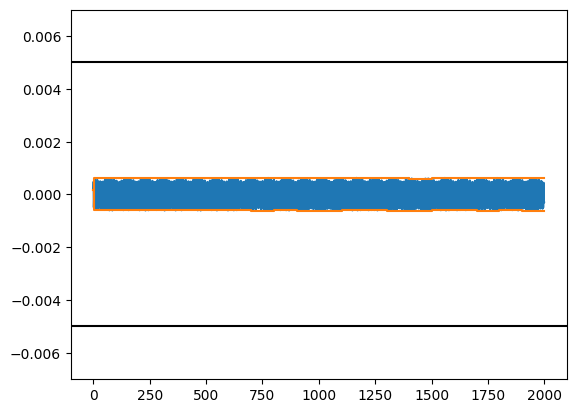

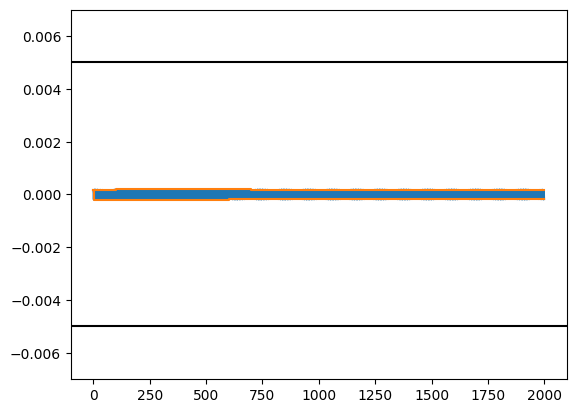

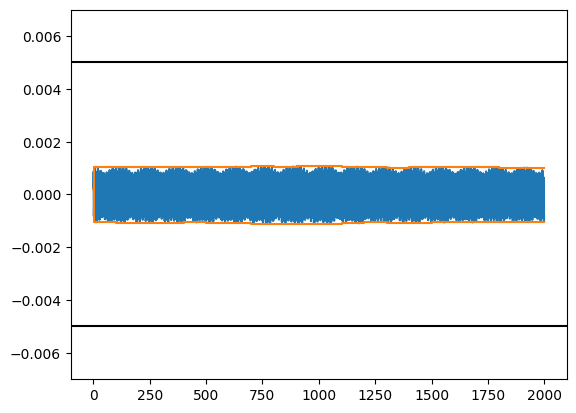

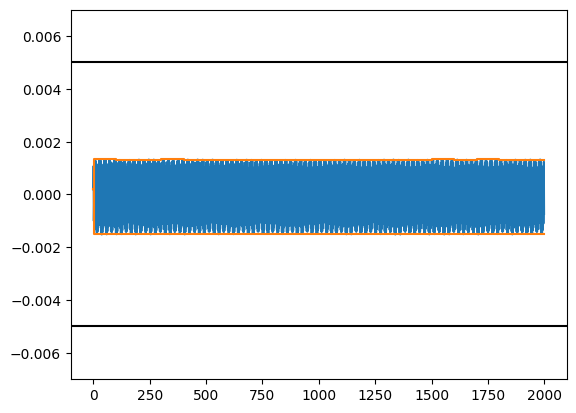

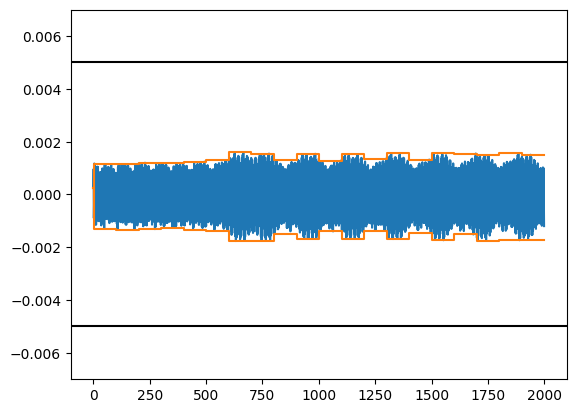

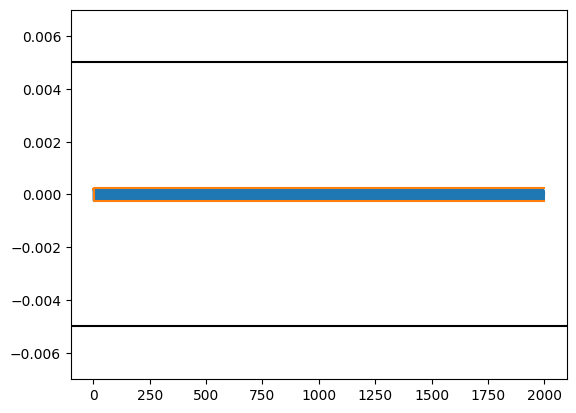

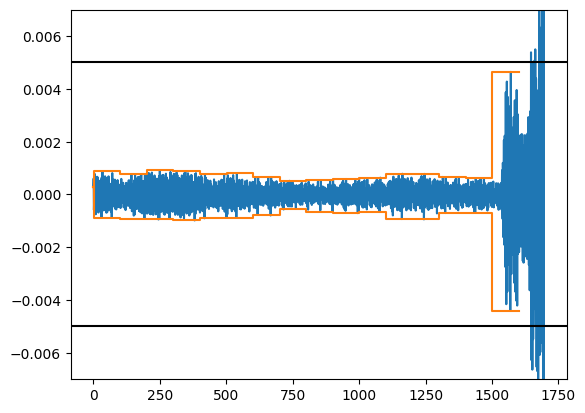

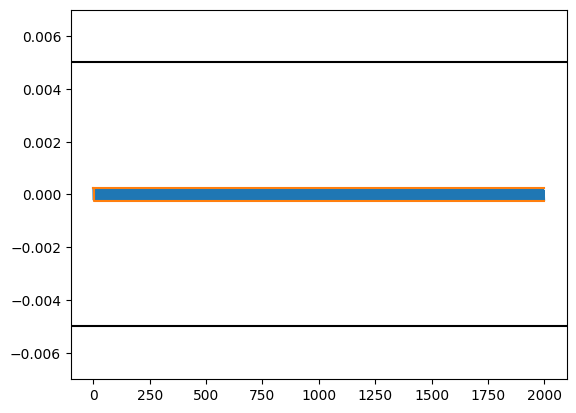

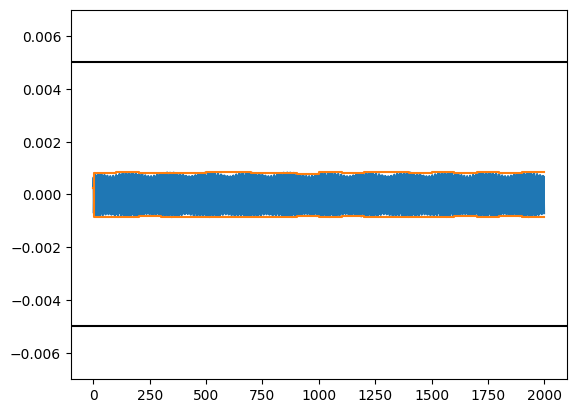

In [6]:

# for (name,df),(name2,calc) in zip(tracked.df.groupby('particle'),calculations.calculations.groupby('particle')):
    # assert name==name2, "Problem with the particle ID"
    # if name in [10,20,30]:

# worst_particles = calculations.calculations.groupby('particle').apply(lambda part: np.max(part.x_max)-np.min(part.x_max)).sort_values(ascending=True).index
for part_ID in np.arange(10,20):
    df = tracked.df.groupby('particle').get_group(part_ID)
    calc = calculations.data.groupby('particle').get_group(part_ID)

    plt.figure()
    plt.plot(df.turn,df.x,'-')
    plt.step(list(calc.start_at_turn) + [list(calc.stop_at_turn)[-1]],list(calc.x_min) + [np.nan],'-',where='post')
    plt.step(list(calc.start_at_turn) + [list(calc.stop_at_turn)[-1]],list(calc.x_max) + [np.nan],'-',where='post',color='C1')
    plt.axhline(0.005,color='k')
    plt.axhline(-0.005,color='k')
    # else:
    #     continue
    plt.ylim([-0.007,0.007])

In [22]:
cst.LHC_F_REV*30*60

20241810.43550021

In [20]:
calculations.data

,BUNCH,Chunk ID,particle,state,start_at_turn,stop_at_turn,x_min,x_max,y_min,y_max,zeta_min,zeta_max,px_min,px_max,py_min,py_max,pzeta_min,pzeta_max
0,224,0,0,1,0,1,0.000025,0.000025,0.000044,0.000044,-1.238537e-06,-1.238537e-06,4.922151e-06,4.922151e-06,0.000003,0.000003,0.000001,0.000001
1,224,0,1,1,0,1,0.000039,0.000039,0.000051,0.000051,-1.462010e-06,-1.462010e-06,5.514488e-06,5.514488e-06,0.000003,0.000003,0.000001,0.000001
2,224,0,2,1,0,1,0.000037,0.000037,0.000029,0.000029,-1.493381e-07,-1.493381e-07,3.019537e-06,3.019537e-06,0.000002,0.000002,0.000001,0.000001
3,224,0,3,1,0,1,0.000052,0.000052,0.000107,0.000107,-4.871396e-06,-4.871396e-06,1.196316e-05,1.196316e-05,0.000002,0.000002,0.000001,0.000001
4,224,0,4,1,0,1,0.000087,0.000087,0.000005,0.000005,1.924507e-06,1.924507e-06,-1.257013e-07,-1.257013e-07,0.000004,0.000004,0.000001,0.000001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420457,224,20,20017,1,1901,2000,-0.000284,0.000271,-0.002353,0.002321,-8.723812e-05,-1.954826e-05,-6.110589e-06,4.786247e-06,-0.000029,0.000028,0.000001,0.000001
420458,224,20,20018,1,1901,2000,-0.000223,0.000226,-0.002711,0.002616,-1.282400e-04,-3.724647e-05,-4.398858e-06,3.968894e-06,-0.000031,0.000034,0.000001,0.000001
420459,224,20,0,0,1901,2000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,NaN,NaN
420460,224,20,0,0,1901,2000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,NaN,NaN


In [19]:
tracked.df

,BUNCH,turn,particle,x,px,y,py,zeta,pzeta,state,at_element
0,224,0,0,0.000025,0.000005,0.000044,3.201929e-06,-0.000001,0.000001,1,0
1,224,1,0,0.000617,-0.000014,0.000501,4.600268e-06,0.000013,0.000001,1,0
2,224,2,0,-0.000451,0.000005,-0.000436,-6.729663e-06,-0.000004,0.000001,1,0
3,224,3,0,-0.000298,0.000011,-0.000152,8.303327e-07,-0.000006,0.000001,1,0
4,224,4,0,0.000665,-0.000012,0.000564,6.173625e-06,0.000013,0.000001,1,0
...,...,...,...,...,...,...,...,...,...,...,...
38167823,224,1769,20021,0.004421,-0.000090,-0.002327,-7.260941e-05,0.000974,0.000001,1,0
38167824,224,1770,20021,-0.002242,0.000008,-0.004093,7.821040e-06,0.000905,0.000001,1,0
38167825,224,1771,20021,-0.006068,0.000132,0.009873,5.891396e-05,0.000868,0.000001,1,0
38167826,224,1772,20021,-0.002537,0.000097,-0.008019,-1.444737e-05,0.001032,0.000002,1,0


(-0.5000000023798511,
 10.500000049976881,
 -0.5000000023798539,
 10.500000049976878)

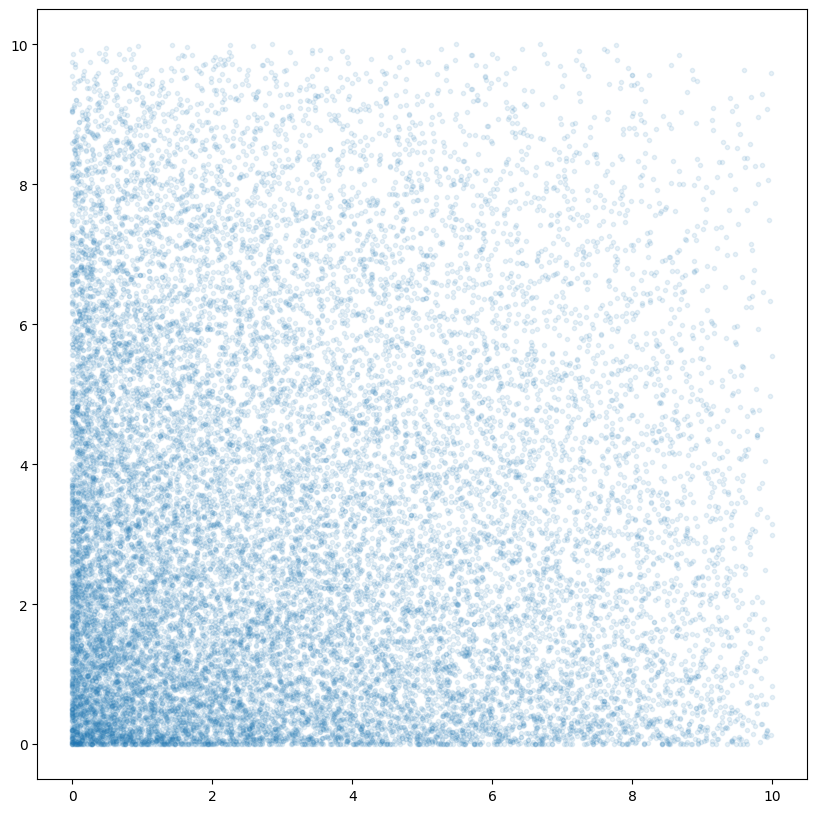

In [18]:
plt.figure(figsize=(10,10))
plt.plot(tracked.coord_sig.x_sig,tracked.coord_sig.px_sig,'.',alpha=0.1)
plt.axis('square')

(-0.5000000023798511,
 10.500000049976872,
 -0.5000000023798513,
 10.500000049976872)

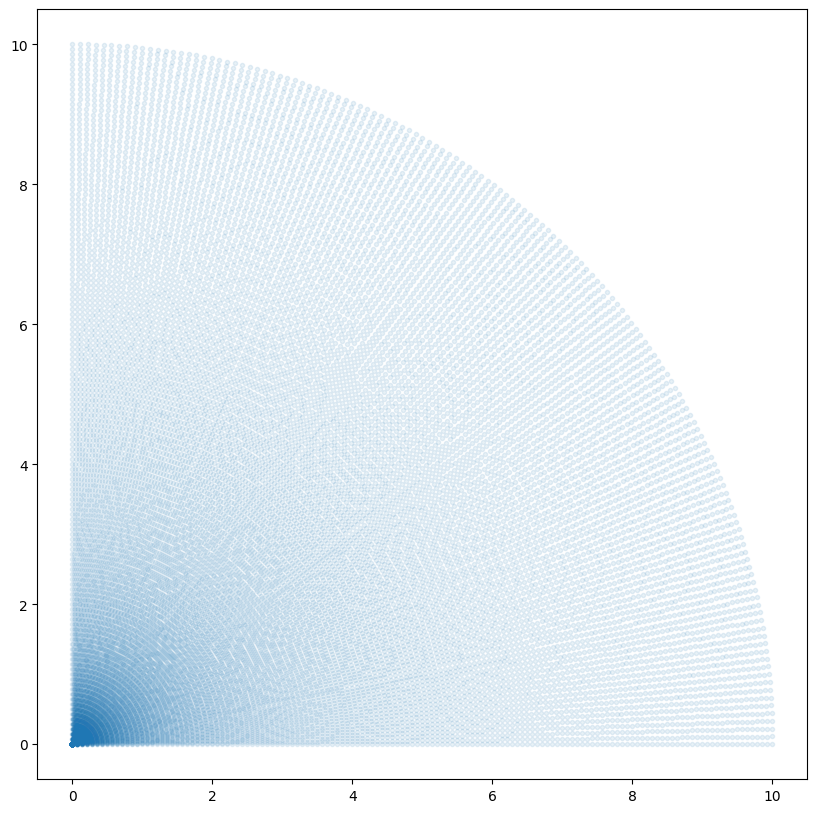

In [17]:
plt.figure(figsize=(10,10))
plt.plot(tracked.coord_sig.x_sig,tracked.coord_sig.y_sig,'.',alpha=0.1)
plt.axis('square')

In [7]:
calculations

╭───────────────────────────── Tracking_Interface ──────────────────────────────╮
│ ╭───────────────────────────────────────────────────────────────────────────╮ │
│ │ <BBStudies.Tracking.XsuitePlus.RenderingTracker object at 0x7fc16aeac5e0> │ │
│ ╰───────────────────────────────────────────────────────────────────────────╯ │
│                                                                               │
│   context_name = 'NoneType'                                                   │
│      exec_time = None                                                         │
│         method = '6d'                                                         │
│        n_parts = 20022                                                        │
│        n_turns = 2000                                                         │
│       nemitt_x = 1.8e-06                                                      │
│       nemitt_y = 1.8e-06                                                      │
│    nemitt_zeta = 1                                                            │
│   parquet_data = '_calculations'                                              │
│ particle_on_co = "<class 'xpart.particles.particles.Particles'>"              │
│   partition_ID = '0224'                                                       │
│ partition_name = 'BUNCH'                                                      │
│  start_at_turn = 0                                                            │
│   stop_at_turn = 2000                                                         │
│       W_matrix = array([[ 1.08863958e+01,  1.33319897e-15,  6.97705688e-01,   │
│                           6.00095910e-01,  1.54562553e-03, -1.91777173e-02],  │
│                         [-2.12445078e-01,  9.11656818e-02, -1.88396282e-02,   │
│                          -5.39780433e-03, -4.18823688e-05, -2.43544501e-04],  │
│                         [-1.00760338e+00,  7.89347783e-01,  1.44622766e+01,   │
│                           1.77111808e-15, -1.51968095e-03,  4.02479004e-04],  │
│                         [-1.57497085e-02,  4.85955640e-03,  1.70152481e-01,   │
│                           6.86240846e-02, -6.02321485e-06,  3.50089345e-06],  │
│                         [ 1.89073344e-01, -4.91944901e-02,  1.54425104e-02,   │
│                           7.79880301e-03,  2.81243720e+01,  3.44424221e-15],  │
│                         [-6.20239284e-06, -4.64857364e-06,  6.00971963e-06,   │
│                           3.07021757e-06, -1.53224931e-04,  3.55563916e-02]]) │
╰───────────────────────────────────────────────────────────────────────────────╯

In [ ]:

# for (name,df),(name2,calc) in zip(tracked.df.groupby('particle'),calculations.calculations.groupby('particle')):
    # assert name==name2, "Problem with the particle ID"
    # if name in [10,20,30]:

# worst_particles = calculations.calculations.groupby('particle').apply(lambda part: np.max(part.x_max)-np.min(part.x_max)).sort_values(ascending=True).index
for part_ID in np.arange(10,20):
    df = tracked.df_n.groupby('particle').get_group(part_ID)
    calc = calculations.calculations.groupby('particle').get_group(part_ID)

    plt.figure()
    plt.plot(df.x_n,df.px_n,'-')
    # plt.step(list(calc.start_at_turn) + [list(calc.stop_at_turn)[-1]],list(calc.x_min) + [np.nan],'-',where='post')
    # plt.step(list(calc.start_at_turn) + [list(calc.stop_at_turn)[-1]],list(calc.x_max) + [np.nan],'-',where='post',color='C1')
    # plt.axhline(0.005,color='k')
    # plt.axhline(-0.005,color='k')
    # else:
    #     continue
    # plt.ylim([-0.007,0.007])
    plt.axis('equal')

In [ ]:
tracked.df[tracked.df['turn']>=901]

In [ ]:
import matplotlib.pyplot as plt
test = calculations._calculations
for part in [0,10,20]:
    plt.figure()
    plt.plot(tracked.df.groupby('particle').get_group(part).turn,tracked.df.groupby('particle').get_group(part).x,'-')
    plt.axhline(test.groupby('start_at_turn').get_group(901).iloc[part].x_min,color='k')
    plt.axhline(test.groupby('start_at_turn').get_group(901).iloc[part].x_max,color='k')
    plt.xlim(900,1000)